In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import datetime as dt
import math
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from matplotlib.pylab import rcParams

In [2]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

In [3]:
df = pd.read_csv('newresultado_join.csv', index_col='Date')
df = df.drop(labels=['Volume', 'polarity', 'subjectivity'], axis=1)
df

,High,Low,Open,Close,Adj Close
Date,,,,,
2017-01-02,60227.0,59371.0,60227.0,59589.0,59589.0
2017-01-03,61815.0,59631.0,59631.0,61814.0,61814.0
2017-01-04,61940.0,61302.0,61811.0,61589.0,61589.0
2017-01-05,62409.0,61594.0,61594.0,62071.0,62071.0
2017-01-06,62072.0,61396.0,62072.0,61665.0,61665.0
...,...,...,...,...,...
2020-12-22,116903.0,115648.0,115825.0,116348.0,116348.0
2020-12-23,118311.0,116636.0,116636.0,117857.0,117857.0
2020-12-28,119213.0,117805.0,117806.0,119051.0,119051.0


In [4]:
X = np.asarray(df.iloc[:738, :-1])
y = np.asarray(df.iloc[:738, -1])

In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y.reshape(-1, 1))

In [7]:
X_scaled.shape

(738, 4)

In [8]:
X_train = []
y_train = []
for i in range(20, len(X)):
    X_train.append(X_scaled[i-20:i,:])
    y_train.append(y_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [9]:
X_train = np.reshape(X_train, (X_train.shape[0], -1))

In [10]:
X_train.shape

(718, 80)

In [11]:
model = xgb.XGBRegressor(n_estimators=25)

In [12]:
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=25, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [13]:
dataset_test = pd.read_csv('newresultado_test.csv', index_col='Date')
dataset_test = dataset_test.drop(labels=['Volume', 'polarity', 'subjectivity'], axis=1)
real_stock_price = dataset_test.iloc[:, 4:5].values

In [14]:
dataset_total = pd.concat((df, dataset_test), axis = 0)
inputs = dataset_total.iloc[len(dataset_total) - len(dataset_test) - 20:, :-1]
inputs = scaler.transform(inputs)

In [15]:
X_test = []
for i in range(20, len(inputs)):
    X_test.append(inputs[i-20:i, :])
X_test = np.array(X_test)

In [16]:
X_test = np.reshape(X_test, (X_test.shape[0], -1))
predicted_stock_price = model.predict(X_test)

In [17]:
y_test_scaled = y_scaler.transform(real_stock_price)
mse = mean_squared_error(y_test_scaled, predicted_stock_price)
mse

0.04269586140761916

In [18]:
predicted_stock_price = y_scaler.inverse_transform(predicted_stock_price)

In [19]:
mae = mean_absolute_error(real_stock_price, predicted_stock_price)
r2 = r2_score(real_stock_price, predicted_stock_price)
mape = mean_absolute_percentage_error(real_stock_price, predicted_stock_price)
mse = mean_squared_error(real_stock_price, predicted_stock_price, squared=False)

print('MAE: %.3f' % mae)
print('R2: %.3f' % r2)
print('MAPE: %.3f' % mape)
print('RMSE: %.3f' % mse)

MAE: 1978.316
R2: 0.952
MAPE: 0.021
RMSE: 2972.264


In [20]:
data_dis = pd.DataFrame(dataset_test, columns=['Adj Close'])
data_dis.dropna(inplace=True)

In [21]:
yhat_dis = pd.DataFrame(predicted_stock_price, index=data_dis.index.copy())

In [22]:
yhat_dis.index = pd.to_datetime(yhat_dis.index)
data_dis.index = pd.to_datetime(data_dis.index)

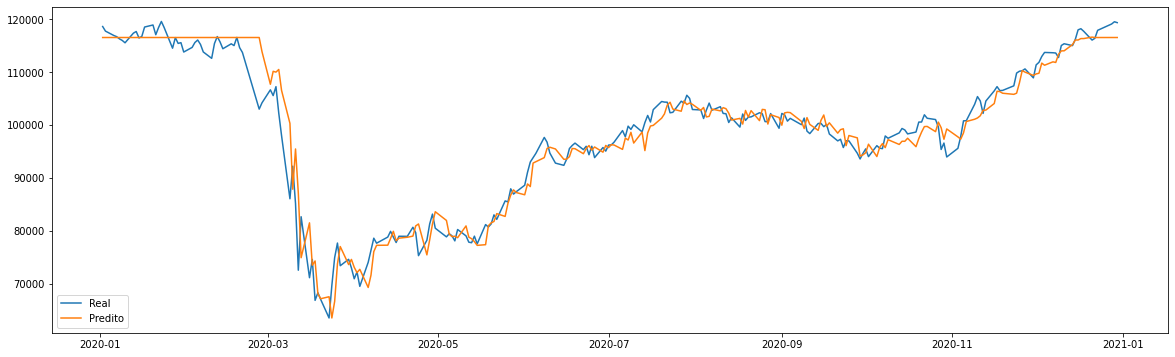

In [23]:
rcParams['figure.figsize'] = 20, 6
plt.pyplot.plot(data_dis, label='Real')
plt.pyplot.plot(yhat_dis, label='Predito')
plt.pyplot.legend()
plt.pyplot.show()